A pytorch implementation of Self-Compressing Neural Networks

https://arxiv.org/pdf/2301.13142

Shows dynamic neural network compression during training - reduced size of weight, activation tensors and bits required to represent weight

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import math
from tqdm import trange
import matplotlib.pyplot as plt
from collections import Counter

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Split data
X_train, Y_train = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))))
X_test, Y_test = next(iter(torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))))

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)>



100%|██████████| 9912422/9912422 [00:23<00:00, 429118.87it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)>



100%|██████████| 28881/28881 [00:00<00:00, 726477.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)>



100%|██████████| 1648877/1648877 [00:02<00:00, 758230.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1000)>



100%|██████████| 4542/4542 [00:00<00:00, 10432929.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
class QConv2d(nn.Module):
    """
    Quantized Conv2d layer starting with 2 bits per weight
    """
    def __init__(self, in_channels, out_channels, kernel_size):
        super(QConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
        scale = 1 / math.sqrt(in_channels * math.prod(self.kernel_size))
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), 2.))  # start with 2 bits per weight

    def qbits(self):
        return self.b.relu().sum() * math.prod(self.weight.shape[1:])

    def qweight(self):
        return torch.minimum(torch.maximum(2**-self.e * self.weight, -2**(self.b.relu()-1)), 2**(self.b.relu()-1) - 1)

    def forward(self, x):
        qw = self.qweight()
        w = (qw.round() - qw).detach() + qw  # straight through estimator
        return nn.functional.conv2d(x, 2**self.e * w)

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            QConv2d(1, 32, 5), nn.ReLU(),
            QConv2d(32, 32, 5), nn.ReLU(),
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.MaxPool2d(2),
            QConv2d(32, 64, 3), nn.ReLU(),
            QConv2d(64, 64, 3), nn.ReLU(),
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(576, 10)  # 576 = 64 * 3 * 3

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

    def qbits(self):
        return sum(l.qbits() for l in self.features if isinstance(l, QConv2d))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
opt = optim.Adam(model.parameters())
test_accs, bytes_used = [], []
weight_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_step():
    model.train()
    opt.zero_grad()
    samples = torch.randint(0, X_train.shape[0], (512,))
    outputs = model(X_train[samples].to(device))
    loss = nn.functional.cross_entropy(outputs, Y_train[samples].to(device))
    Q = model.qbits() / weight_count
    loss = loss + 0.05 * Q  # hyperparameter determines compression vs accuracy
    loss.backward()
    opt.step()
    return loss.item(), Q.item()

def get_test_acc():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        pred = outputs.argmax(dim=1)
        return (pred == Y_test.to(device)).float().mean().item() * 100

test_acc = 0.0
test_accs, bytes_used = [], []
# Training loop
for i in (t := trange(4000)):
    loss, Q = train_step()
    model_bytes = Q / 8 * weight_count
    if i % 10 == 9:
        test_acc = get_test_acc()
    test_accs.append(test_acc)
    bytes_used.append(model_bytes)
    t.set_description(f"loss: {loss:6.2f}  bytes: {model_bytes:.1f}  acc: {test_acc:5.2f}%")

loss:   0.13  bytes: 18403.9  acc: 97.77%: 100%|██████████| 4000/4000 [05:37<00:00, 11.86it/s]


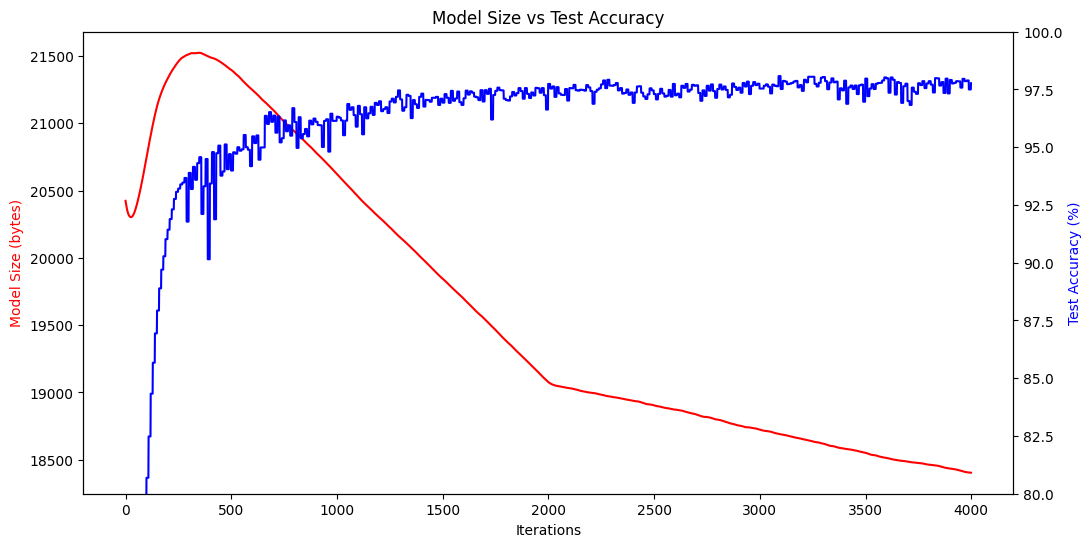

In [5]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot model size
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Model Size (bytes)', color='red')
ax1.plot(bytes_used, color='red')
ax1.tick_params(axis='y')

# Plot test accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Test Accuracy (%)', color='blue')
ax2.plot(test_accs, color='blue')
ax2.tick_params(axis='y')

ax2.set_ylim(80, 100)
plt.title('Model Size vs Test Accuracy')
plt.show()

In [63]:
# Sanity check
for name, param in model.named_parameters():
    if name.endswith(".b") or name.endswith(".e"):
        print(name, param.shape, param.detach().cpu().numpy().flatten()[:10])

for i, l in enumerate(model.features):
    if isinstance(l, QConv2d):
        print(f"QConv2d {i} weights", [x[1] for x in sorted(Counter(l.qweight().round().detach().cpu().numpy().flatten().tolist()).items())])

features.0.e torch.Size([32, 1, 1, 1]) [-8.362031  -7.5582986 -8.371059  -7.673241  -8.307985  -8.006771
 -7.6571426 -8.212281  -8.377497  -7.658069 ]
features.0.b torch.Size([32, 1, 1, 1]) [1.861303  1.5844141 2.0087297 1.2339685 2.3218937 2.3230042 2.3185906
 1.583619  2.322591  2.3118079]
features.2.e torch.Size([32, 1, 1, 1]) [-8.251526  -7.9970675 -7.304925  -8.290237  -7.9626465 -8.022847
 -8.181926  -8.058747  -8.026559  -8.875323 ]
features.2.b torch.Size([32, 1, 1, 1]) [ 2.3214393  -0.00983464  2.3229685   1.5062286  -0.00899656 -0.008847
  2.3250458   2.1145906  -0.00979975  2.322049  ]
features.6.e torch.Size([64, 1, 1, 1]) [-7.292215  -7.663757  -7.810132  -7.943962  -7.924144  -7.822552
 -7.7278657 -7.859132  -7.4150224 -7.929284 ]
features.6.b torch.Size([64, 1, 1, 1]) [2.6215775 1.9788694 2.5301628 1.6205384 2.362529  2.589998  2.1299837
 1.5404483 2.8129125 1.6192201]
features.8.e torch.Size([64, 1, 1, 1]) [-7.767816  -7.891883  -7.745182  -7.825889  -7.9688644 -7.71804